In [1]:
import torch
from dlc_practical_prologue import generate_pair_sets
import torch.nn as nn
from print_util import *
from utils import *
import time

## 1. Generate raw data, process it

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [3]:
train_input, train_target, train_classes, test_input, test_target, test_classes = generate_data_device(1000, device=device)

_We normalized the data so it has mean 0 and std 1._

In [4]:
train_input = normalize_data(train_input)
test_input = normalize_data(test_input)

_We will create a validation set to tune hyperparameters. This validation set is created from the training set in order to have fully independent testing data._

_80% of the training data goes to training and the remaining 20% for our validation set._

In [5]:
index_permutation = torch.randperm(train_input.size(0))

validation_proportion = 0.2
split = int(0.2 * train_input.size(0))

validation_index = index_permutation[:split]
training_index = index_permutation[split:]

validation_input = train_input[validation_index]
validation_target = train_target[validation_index]
validation_classes = train_classes[validation_index]

train_input = train_input[training_index]
train_target = train_target[training_index]
train_classes = train_classes[training_index]

In [6]:
print(train_input.size(0))
print(validation_input.size(0))

800
200


## 2. Creating & Training models

In [7]:
import models
import torch.nn.functional as F

In [8]:
BATCH_SIZE = 64
architecture = models.SiameseNetwork

In [9]:
def test(test_input, test_target, test_classes, model, criterion, batch_size, aux=0.0):
    model.eval()  # Switch to eval mode in case we use an architecture that requires it
    with torch.no_grad():
        nb_final_errors = 0
        nb_digit_errors = 0
        loss_sum = 0
        
        for inputs, classes, targets in zip(test_input.split(batch_size), 
                                            test_classes.split(batch_size), 
                                            test_target.split(batch_size)):

            classes1, classes2 = classes[:, 0], classes[:, 1]
            inputs1, inputs2 = separate_channels(inputs)
            outputs1, outputs2 = model.digit_pred(inputs1), model.digit_pred(inputs2)
            loss_digit = criterion(outputs1, classes1) + criterion(outputs2, classes2)
            loss_sum += aux * loss_digit
            _, predicted1 = torch.max(outputs1, 1)
            _, predicted2 = torch.max(outputs2, 1)

            for k in range(len(inputs)):
                if classes1[k] != predicted1[k]:
                    nb_digit_errors += 1
                if classes2[k] != predicted2[k]:
                    nb_digit_errors += 1
            
            outputs = model(inputs)
            loss_final = criterion(outputs, targets)
            loss_sum += loss_final
            _, predicted = torch.max(outputs, 1)
            
            for k in range(len(inputs)):
                if targets[k] != predicted[k]:
                    nb_final_errors += 1

        final_acc = (1 - (nb_final_errors / test_input.size(0))) * 100
        digit_acc = (1 - (nb_digit_errors / (test_input.size(0) * 2))) * 100
        
        return final_acc, digit_acc, loss_sum.item()

In [10]:
def train_model(model, train_input, train_target, train_classes, test_input, test_target, test_classes,
                nb_epochs, batch_size, optimizer_params, logging = False, aux=0.0):
    lr, momentum, weight_decay, gamma = optimizer_params['lr'], optimizer_params['momentum'], optimizer_params['weight_decay'], optimizer_params['gamma']    
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
    criterion = nn.CrossEntropyLoss()
    
    if logging:
        log_acc_loss_header(color=Color.GREEN, aux=True)
    
        train_final_accuracies = []
        train_digit_accuracies = []
        train_losses = []
        test_final_accuracies = []
        test_digit_accuracies = []
        test_losses = []
        start_time = time.time()
    
    for e in range(nb_epochs):
        model.train()  # Switch to train mode in case we use an architecture that requires it
        for inputs, targets, classes in zip(train_input.split(batch_size),
                                            train_target.split(batch_size),
                                            train_classes.split(batch_size)):
            
            inputs1, inputs2 = separate_channels(inputs)
            outputs1, outputs2 = model.digit_pred(inputs1), model.digit_pred(inputs2)
            loss_digit = criterion(outputs1, classes[:, 0]) + criterion(outputs2, classes[:, 1])
            loss = aux * loss_digit
                
            outputs = model(inputs)
            loss_final = criterion(outputs, targets)
            loss += loss_final
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        scheduler.step()  # Update the learning rate
        
        if logging:
            train_final_acc, train_digit_acc, train_loss = test(train_input, train_target, train_classes, model, criterion, batch_size, aux=aux)
            test_final_acc, test_digit_acc, test_loss = test(test_input, test_target, test_classes, model, criterion, batch_size, aux=aux)
        
            train_final_accuracies.append(train_final_acc)
            train_digit_accuracies.append(train_digit_acc)
            train_losses.append(train_loss)
            
            test_final_accuracies.append(test_final_acc)
            test_digit_accuracies.append(test_digit_acc)
            test_losses.append(test_loss)
        
            elapsed_time = time.time() - start_time
            log_acc_loss_aux(e, nb_epochs, elapsed_time, train_loss, train_final_acc, train_digit_acc, test_loss, test_final_acc, test_digit_acc, persistent=False)
            
    if logging:
        print()
        return train_final_accuracies, train_digit_accuracies, train_losses, test_final_accuracies, test_digit_accuracies, test_losses

In [11]:
optimizer_params = {'lr': 0.05, 'momentum':0.9, 'weight_decay': 0., 'gamma': 0.97}
nb_epochs = 50

First we try to train the model without the auxiliary loss (aux=0.)

In [12]:
model = architecture(nb_conv=2, final_bias=True).to(device=device)
train_accuracies, train_digit_accuracies, train_losses, \
test_accuracies, test_digit_accuracies, test_losses = train_model(model, train_input, train_target, train_classes,
                   test_input, test_target, test_classes, 
                   nb_epochs, BATCH_SIZE, optimizer_params,
                   logging=True, aux=0.)

Epoch       Time    Train loss     Train acc      Train digit acc     Test loss      Test acc       Test digit acc      
[50/50]     107s    0.0027         100.0000       4.0000              16.9147        85.0000        4.7500              


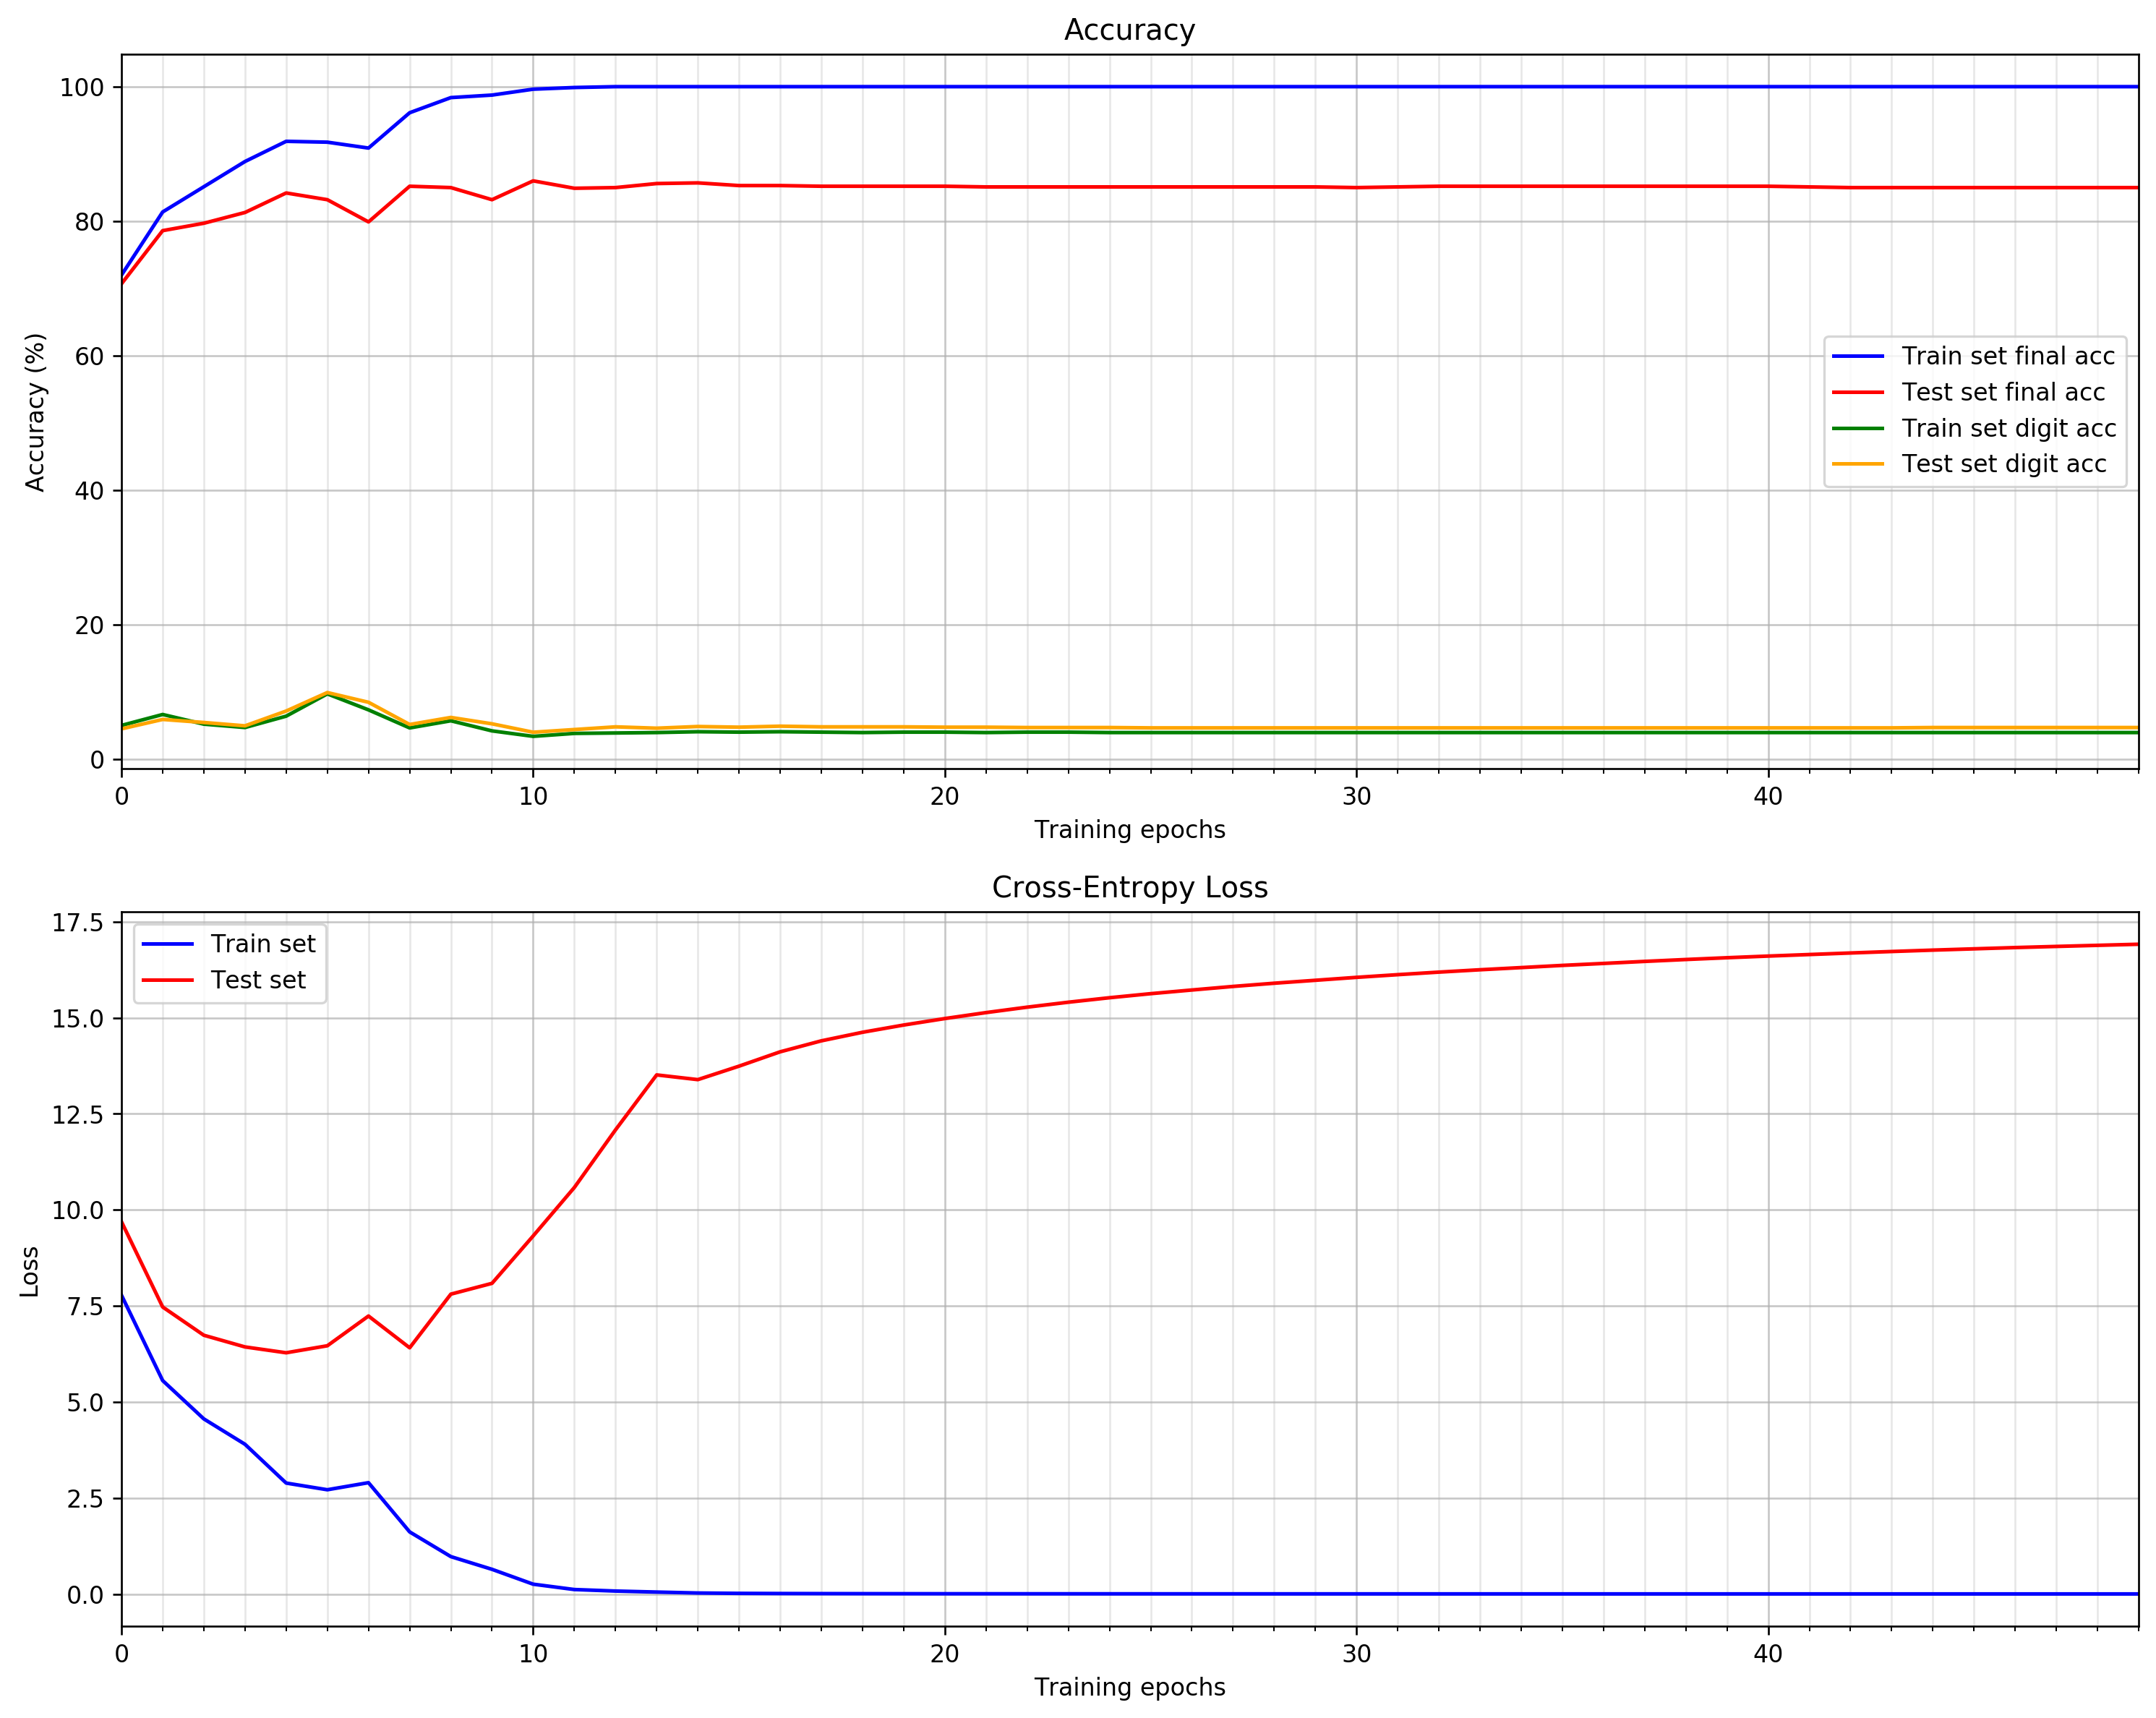

In [13]:
plot_acc_loss_aux(train_accuracies, train_digit_accuracies, train_losses, test_accuracies, test_digit_accuracies, test_losses)

## 3. Finding a good auxiliary factor

We check which auxiliary loss factor is the best. We do that with 5 independent trainings for each auxiliary loss tested (to reduce variance), so the next cell takes a long time to run even with a decent GPU.

In [14]:
run_cell = True
reruns = 5
if run_cell:
    auxs = [0.0, 0.1, 0.2, 0.3, 0.35, 0.4, 0.45, 0.5]  # More than 0.5 sometimes causes training to fail
    best_accuracy = 0
    best_aux = 0
    for aux in auxs:
        accuracies, digit_accuracies, losses = [0.] * reruns, [0.] * reruns, [0.] * reruns
        for run in range(reruns):
            model = architecture(nb_conv=2, final_bias=True).to(device=device)
            train_model(model,
                        train_input,
                        train_target,
                        train_classes,
                        None,
                        None,
                        None,
                        nb_epochs, BATCH_SIZE, optimizer_params, logging=False, aux=aux)
            # compute accuracy on validation data
            accuracies[run], digit_accuracies[run], losses[run] = test(validation_input, validation_target, validation_classes, model, nn.CrossEntropyLoss(), BATCH_SIZE, aux=aux)
        
        accuracy = sum(accuracies) / len(accuracies)
        print("Aux: " + repr(aux) + " => Average accuracy: " + repr(accuracy))

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_aux = aux
    
    print("Note that these accuracies are obtained with 80% of the training data only")
    print("Best accuracy obtained = {a}".format(a = best_accuracy))
    print("with the following aux factor: " + repr(best_aux))

Aux: 0.0 => Average accuracy: 77.7
Aux: 0.1 => Average accuracy: 81.6
Aux: 0.2 => Average accuracy: 84.1
Aux: 0.3 => Average accuracy: 84.6
Aux: 0.35 => Average accuracy: 85.3
Aux: 0.4 => Average accuracy: 85.8
Aux: 0.45 => Average accuracy: 85.0
Aux: 0.5 => Average accuracy: 85.2
Note that these accuracies are obtained with 80% of the training data only
Best accuracy obtained = 85.8
with the following aux factor: 0.4


Unfortunately with aux factor too high the training sometimes fails, so we'll use aux = 0.4

In [15]:
aux = 0.4

## 4. Testing different learning schemes

### 4.1 Train digit prediction only, then comparison only

In [16]:
nb_epochs = 25
model = architecture(nb_conv=2, final_bias=True).to(device=device)
model.digit_comp_req_grad(False)  # We freeze the learning of the final linear layer for the first 25 epochs
_, _, _, _, _, _ = train_model(model, train_input, train_target, train_classes,
                   test_input, test_target, test_classes, 
                   nb_epochs, BATCH_SIZE, optimizer_params,
                   logging=True, aux=aux)
model.digit_comp_req_grad(True)  # We unfreeze the learning of the final linear layer
model.digit_pred_req_grad(False)  # We freeze the learning of the digit predictor
_, _, _, _, _, _ = train_model(model, train_input, train_target, train_classes,
                   test_input, test_target, test_classes, 
                   nb_epochs, BATCH_SIZE, optimizer_params,
                   logging=True, aux=aux)

Epoch       Time    Train loss     Train acc      Train digit acc     Test loss      Test acc       Test digit acc      
[25/25]     52s     5.0834         76.1250        100.0000            19.6186        64.8000        91.1500             
Epoch       Time    Train loss     Train acc      Train digit acc     Test loss      Test acc       Test digit acc      
[25/25]     46s     4.7353         75.3750        100.0000            32.5798        65.1000        91.1500             


As we can see the digit predictor accuracy is quite good (91.2%) but the final test accuracy is very bad (65%)

### 4.2 Train digit prediction only, then everything

In [25]:
nb_epochs = 25
model = architecture(nb_conv=2, final_bias=True).to(device=device)
model.digit_comp_req_grad(False)  # We freeze the learning of the final linear layer for the first 25 epochs
_, _, _, _, _, _ = train_model(model, train_input, train_target, train_classes,
                   test_input, test_target, test_classes, 
                   nb_epochs, BATCH_SIZE, optimizer_params,
                   logging=True, aux=aux)
model.digit_comp_req_grad(True)  # We unfreeze the learning of the final linear layer for the last 25 epochs
_, _, _, _, _, _ = train_model(model, train_input, train_target, train_classes,
                   test_input, test_target, test_classes, 
                   nb_epochs, BATCH_SIZE, optimizer_params,
                   logging=True, aux=aux)

Epoch       Time    Train loss     Train acc      Train digit acc     Test loss      Test acc       Test digit acc      
[25/25]     53s     0.0477         100.0000       100.0000            21.6139        87.0000        90.1500             
Epoch       Time    Train loss     Train acc      Train digit acc     Test loss      Test acc       Test digit acc      
[25/25]     53s     0.0215         100.0000       100.0000            20.5113        89.8000        93.5000             


The first learning reached a quite good test digit accuracy as before, and the final accuracy is already much better, but sometimes the training simply fails and does not converge.

### 4.3 Train everything since the beginning

In [18]:
nb_epochs = 50
# We train everything for 50 epochs
model = architecture(nb_conv=2, final_bias=True).to(device=device)
_, _, _, _, _, _ = train_model(model, train_input, train_target, train_classes,
                   test_input, test_target, test_classes, 
                   nb_epochs, BATCH_SIZE, optimizer_params,
                   logging=True, aux=aux)

Epoch       Time    Train loss     Train acc      Train digit acc     Test loss      Test acc       Test digit acc      
[50/50]     104s    0.0074         100.0000       100.0000            21.5529        89.9000        91.2500             


This time the test accuracy is even better and it does not seem to ever fail training with our hyperparameters. From now on we'll only use this scheme.

## 5. Trying different depths

### 2 convolutionnal layers

Epoch       Time    Train loss     Train acc      Train digit acc     Test loss      Test acc       Test digit acc      
[50/50]     104s    0.0101         100.0000       100.0000            18.9460        90.5000        92.5000             


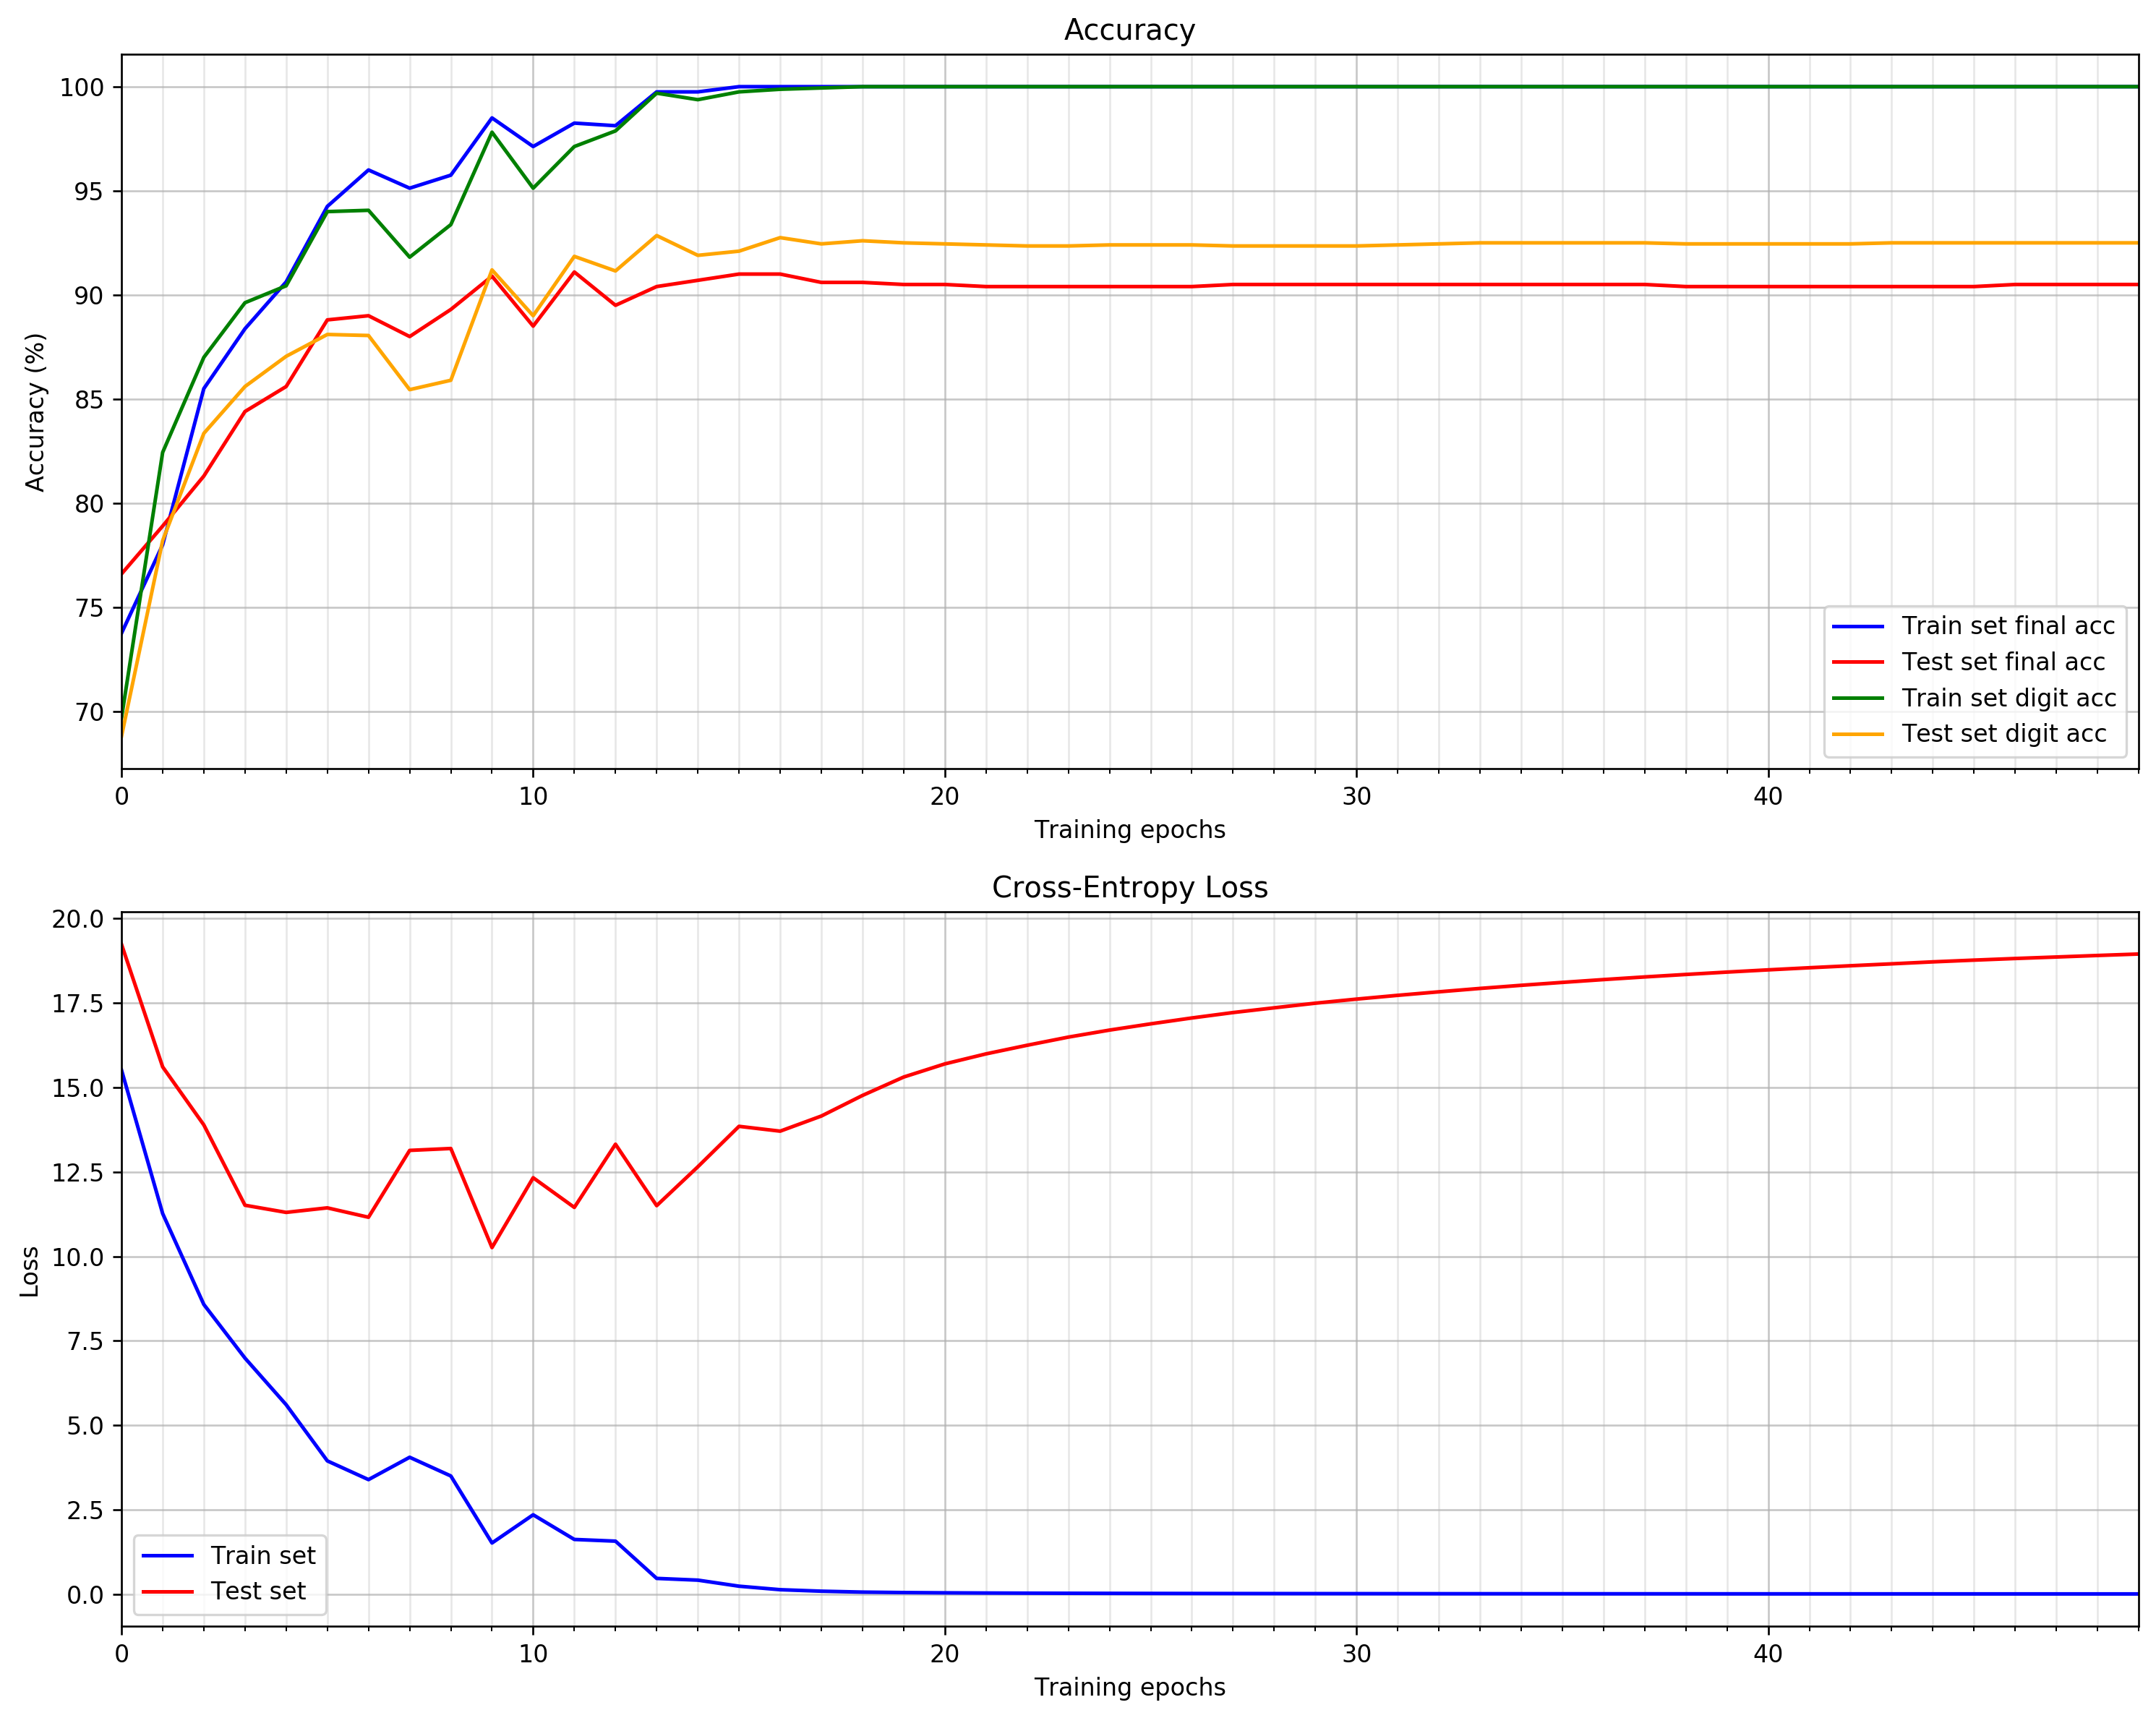

In [19]:
nb_epochs = 50
nb_conv = 2
# We train everything for 50 epochs
model = architecture(nb_conv=nb_conv, final_bias=True).to(device=device)
train_accuracies, train_digit_accuracies, train_losses, \
test_accuracies, test_digit_accuracies, test_losses = train_model(model, train_input, train_target, train_classes,
                                                       test_input, test_target, test_classes, 
                                                       nb_epochs, BATCH_SIZE, optimizer_params,
                                                       logging=True, aux=aux)
plot_acc_loss_aux(train_accuracies, train_digit_accuracies, train_losses, test_accuracies, test_digit_accuracies, test_losses)

### 3 convolutionnal layers

Epoch       Time    Train loss     Train acc      Train digit acc     Test loss      Test acc       Test digit acc      
[50/50]     112s    0.0043         100.0000       100.0000            23.0424        90.6000        92.2000             


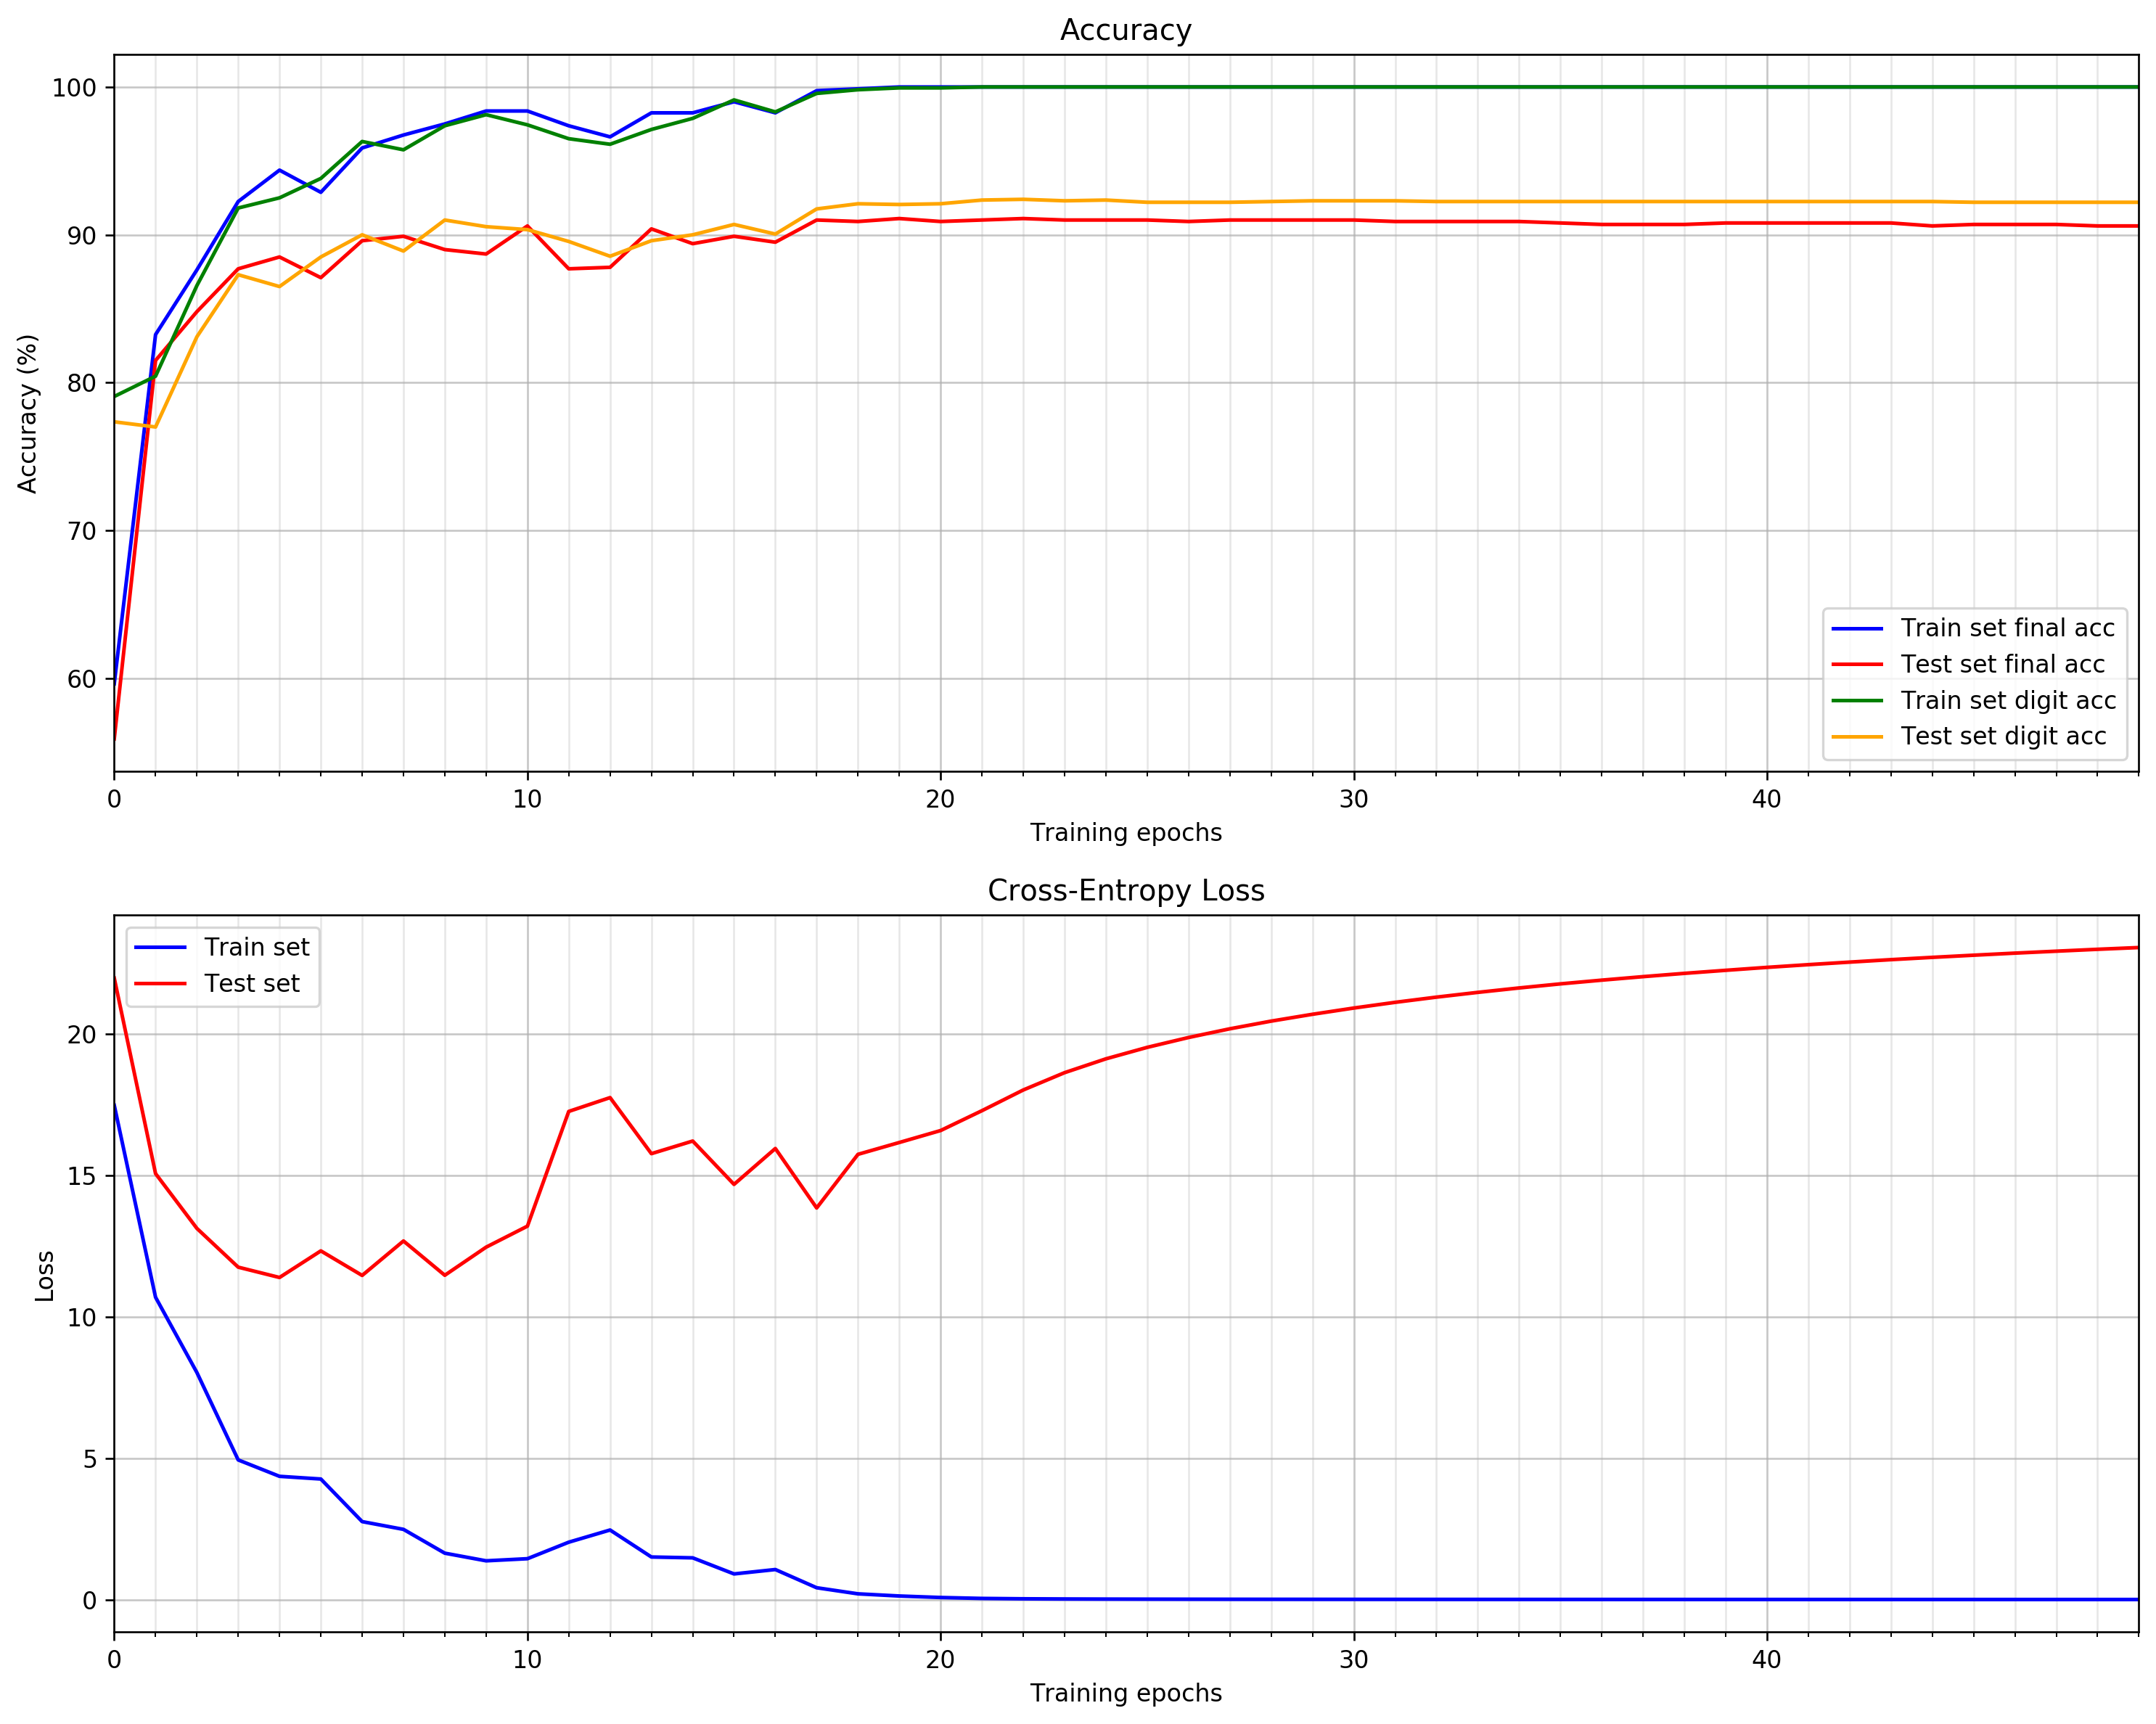

In [20]:
nb_epochs = 50
nb_conv = 3
# We train everything for 50 epochs
model = architecture(nb_conv=nb_conv, final_bias=True).to(device=device)
train_accuracies, train_digit_accuracies, train_losses, \
test_accuracies, test_digit_accuracies, test_losses = train_model(model, train_input, train_target, train_classes,
                                                       test_input, test_target, test_classes, 
                                                       nb_epochs, BATCH_SIZE, optimizer_params,
                                                       logging=True, aux=aux)
plot_acc_loss_aux(train_accuracies, train_digit_accuracies, train_losses, test_accuracies, test_digit_accuracies, test_losses)

### 4 convolutionnal layers

Epoch       Time    Train loss     Train acc      Train digit acc     Test loss      Test acc       Test digit acc      
[50/50]     122s    0.0032         100.0000       100.0000            32.2794        90.4000        92.1000             


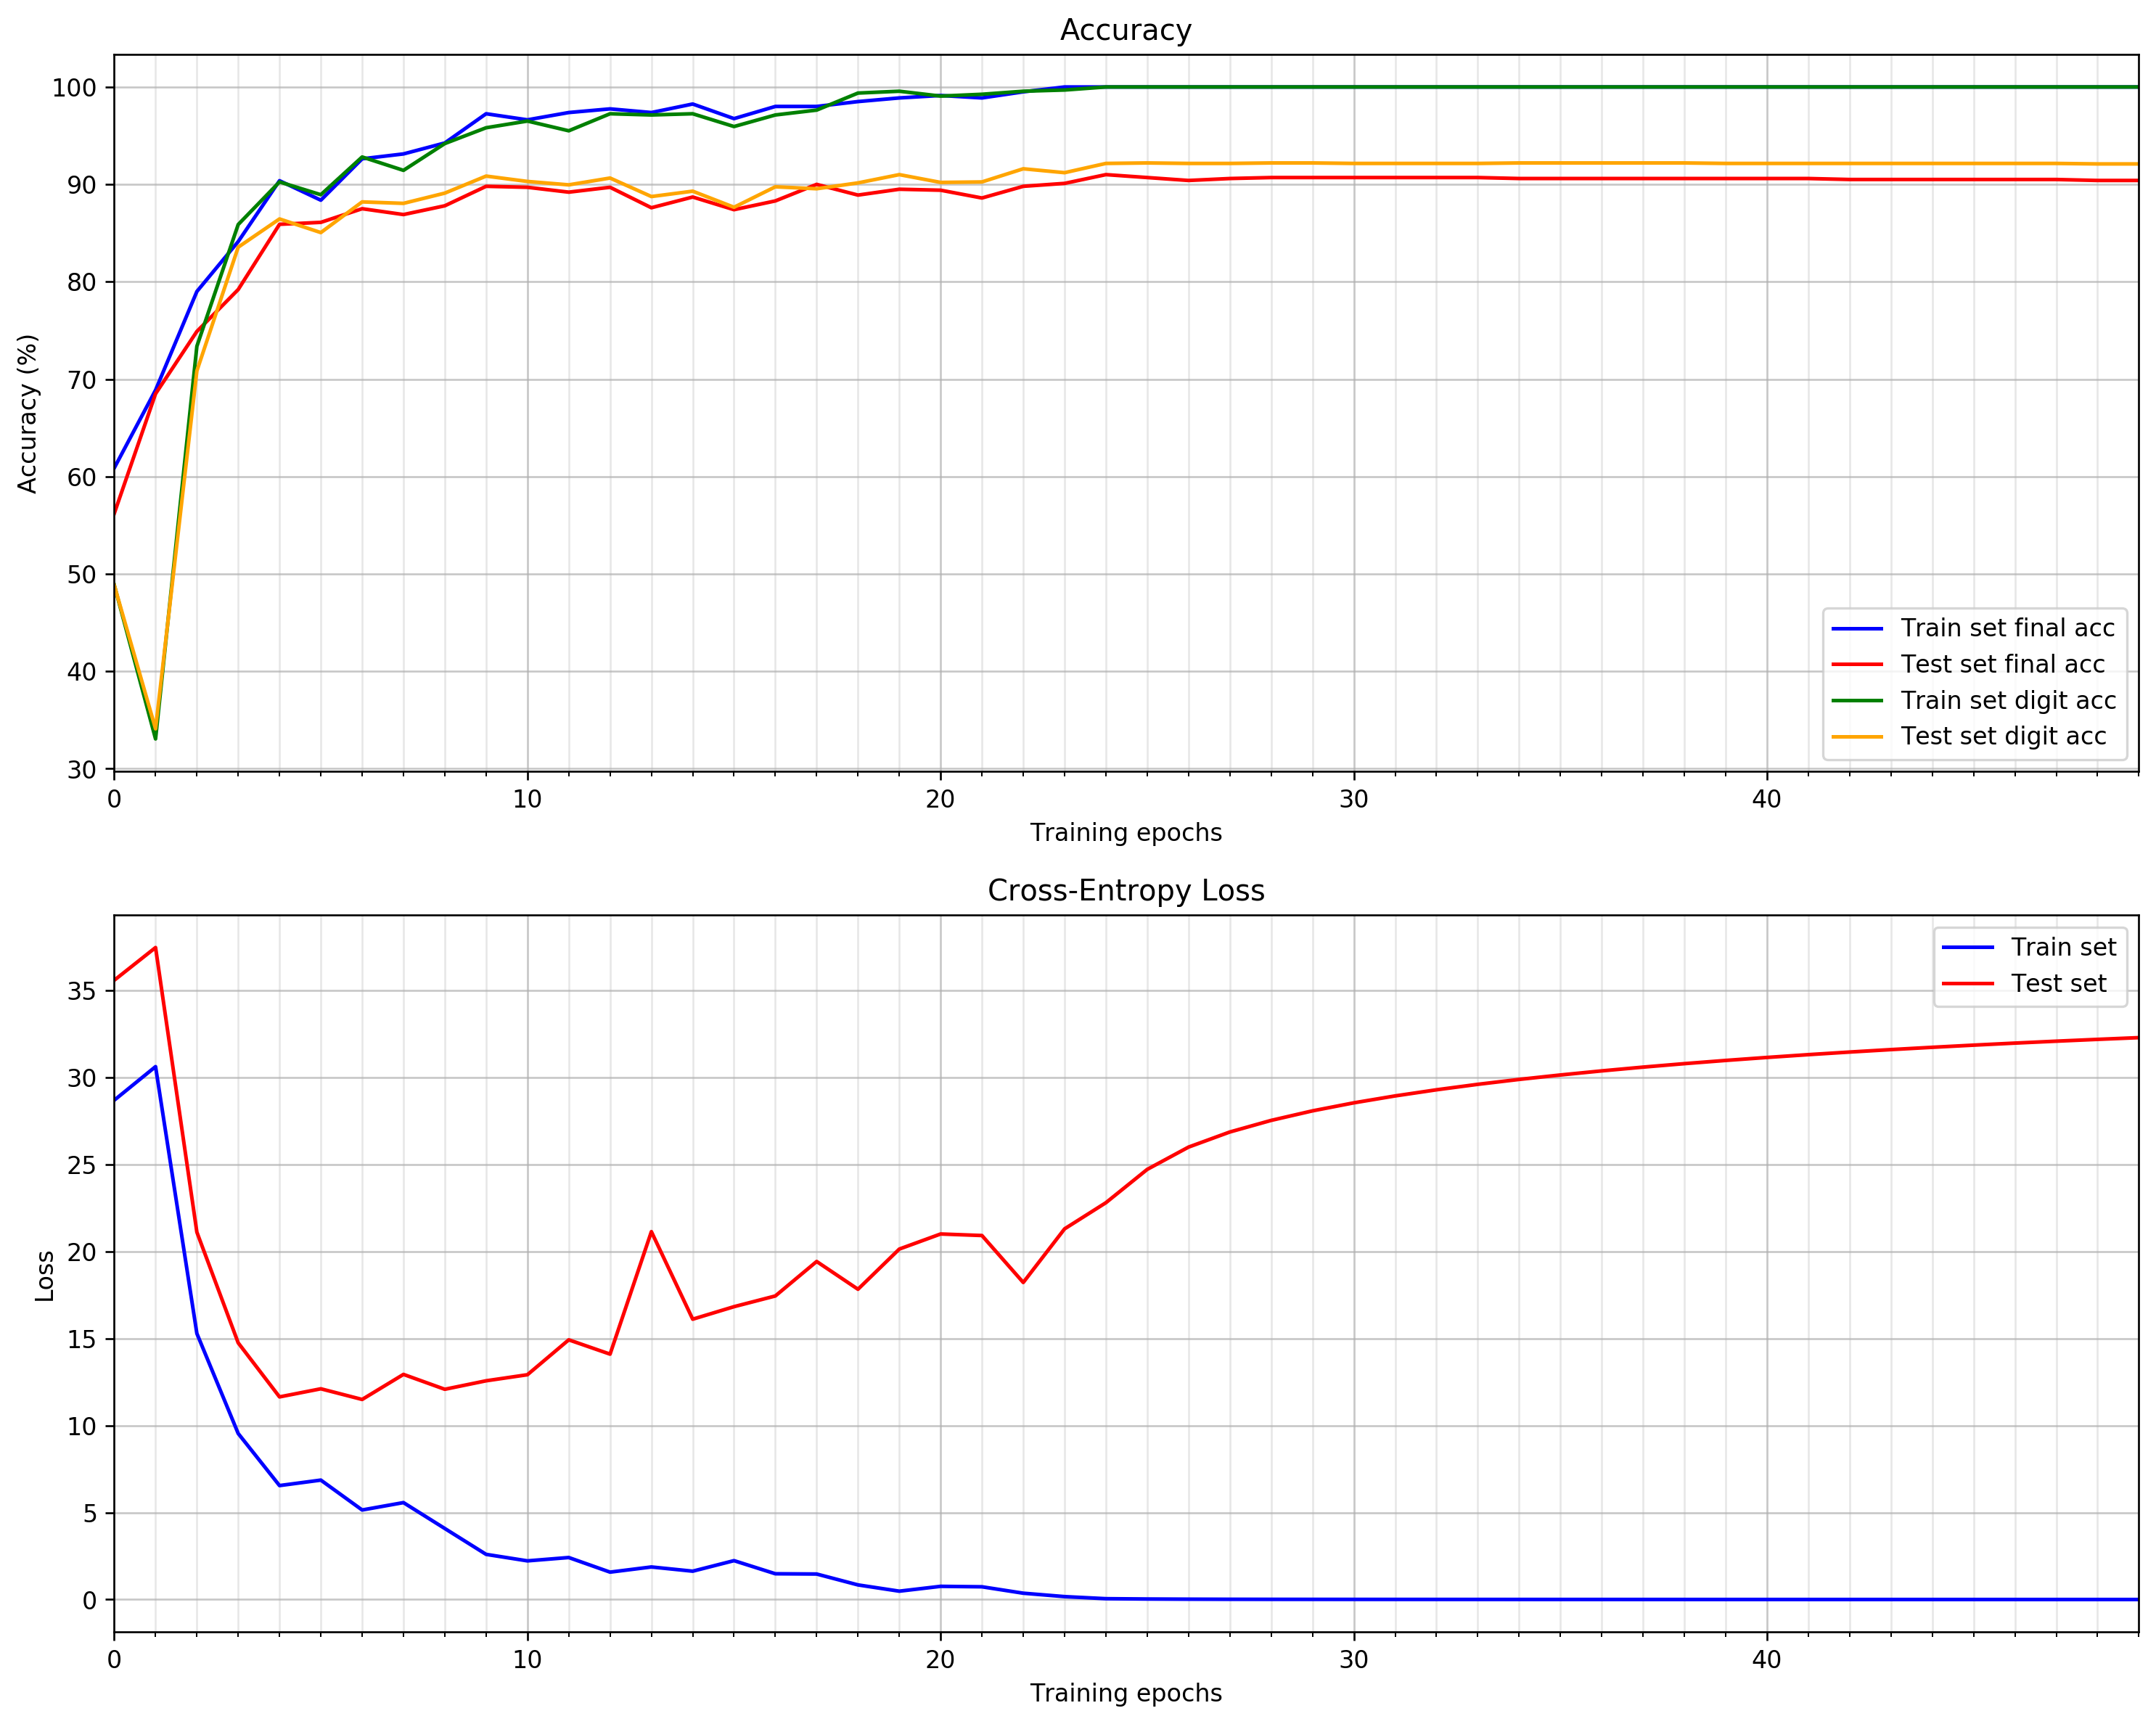

In [21]:
nb_epochs = 50
nb_conv = 4
# We train everything for 50 epochs
model = architecture(nb_conv=nb_conv, final_bias=True).to(device=device)
train_accuracies, train_digit_accuracies, train_losses, \
test_accuracies, test_digit_accuracies, test_losses = train_model(model, train_input, train_target, train_classes,
                                                       test_input, test_target, test_classes, 
                                                       nb_epochs, BATCH_SIZE, optimizer_params,
                                                       logging=True, aux=aux)
plot_acc_loss_aux(train_accuracies, train_digit_accuracies, train_losses, test_accuracies, test_digit_accuracies, test_losses)

The architecture with 4 convolutional layers seems to have the highest final test accuracy, but it sometimes fails while learning (accuracy is stuck at ~50%).
Also, we can see from the plots that the model with 2 convolutional layers needs less epochs to converge, but it still has a lower accuracy.
Therefore as our final model we'll use the one with 3 conv layers.

## 6. Testing model

_In order to test the model we will generate new data (training and test set), retrained the model on the new data en evaluate it on the new test set. We will do this process more than 10 times and estimates the mean accuracy as well as its standard deviation._

In [22]:
def evaluate_model(model, nb_rounds, criterion):
    accuracies = []
    log_evaluate_header(color=Color.GREEN)
    
    for round in range(nb_rounds):
        # initialize new model
        model_evaluated = model(nb_conv=nb_conv, final_bias=True).to(device=device)
        # generate new data
        train_input, train_target, train_classes, test_input, test_target, test_classes = generate_data_device(1000, device=device)
        train_input = normalize_data(train_input)
        test_input = normalize_data(test_input)
        
        train_model(model_evaluated,
                    train_input, train_target, train_classes,
                    None, None, None,
                    nb_epochs, BATCH_SIZE, 
                    optimizer_params, aux=aux)
        
        accuracy, _, loss = test(test_input, test_target, test_classes, model_evaluated, criterion, BATCH_SIZE, aux=aux)
        log_evaluate(round, nb_rounds, accuracy, loss, persistent=True)
        accuracies.append(accuracy)
        
    return torch.FloatTensor(accuracies)

In [23]:
optimizer_params = {'lr': 0.05, 'momentum':0.9, 'weight_decay': 0., 'gamma': 0.98}
nb_epochs = 100  # We use a bit higher gamma and more epochs
nb_conv = 3
nb_rounds = 25  # We use 25 reruns because of the high variance, reduce it to make the cell faster
accuracies = evaluate_model(architecture, nb_rounds, nn.CrossEntropyLoss())

Round       Test accuracy       Test loss      
[1/25]      89.7000             26.8513        
[2/25]      90.9000             25.8297        
[3/25]      88.7000             23.9026        
[4/25]      89.7000             20.3431        
[5/25]      89.6000             24.5589        
[6/25]      91.5000             19.5490        
[7/25]      91.2000             20.7077        
[8/25]      93.7000             16.2252        
[9/25]      90.7000             23.3813        
[10/25]     89.5000             26.3711        
[11/25]     91.9000             22.0935        
[12/25]     90.2000             18.4924        
[13/25]     90.8000             23.3043        
[14/25]     89.8000             24.9088        
[15/25]     90.5000             22.2614        
[16/25]     93.1000             17.8739        
[17/25]     92.0000             17.8007        
[18/25]     92.5000             19.1269        
[19/25]     89.5000             24.8704        
[20/25]     91.8000             19.1354 

In [24]:
print("The mean accuracy is: {a:0.2f}".format(a = accuracies.mean()))
print("The accuracy standard deviation is: {s:0.4f}".format(s = accuracies.std()))

The mean accuracy is: 90.94
The accuracy standard deviation is: 1.2315
